In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import os
import re
import matplotlib.pyplot as plt

# Modelling
from gensim.models import Word2Vec
from gensim import models
from sklearn.model_selection import train_test_split

from time import time

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparasion

In [11]:
songId_song_map = {}
songId_artist_map = {}
track_playlist_map = {}
playlists_name = []
all_playlists = []
train_list = []
test_list = []
list_song_num = {}
vocabulary = {}

path = '/content/drive/MyDrive/DATA 240 Data Mining/240_project/data_first10000'

In [12]:
# read json files
def process_mpd(path, filter=False):
  files = os.listdir(path)
  for filename in files:
    if filename.startswith('mpd.slice.') and filename.endswith('.json'):
      full_path = os.sep.join((path, filename))
      f = open(full_path)
      js = f.read()
      f.close()
      slice = json.loads(js)
      for playlist in slice['playlists']:
        all_playlists.append(playlist)
  list_train, list_test = train_test_split(all_playlists, test_size=0.05, shuffle=True, random_state=42)
  process_playlist(list_train, train_list, filter)
  process_playlist(list_test, test_list, filter)

show distribution of number of songs in the playlist

In [13]:
def process_playlist(playlist, save_list, filter):
  # only keep playlists length between 10 - 100 
  # remove all duplicate traks in each playlist
  min_tracks_per_playlist = 10
  max_tracks_per_playlist = 100
  for item in playlist:
    # process the songs in the list
    temp = []
    if filter:
      if item['num_tracks'] < min_tracks_per_playlist or \
          item['num_tracks'] > max_tracks_per_playlist:
        continue
    
    # check how many songs in a playlist
    num = item['num_tracks']
    list_song_num[num] = list_song_num.get(num, 0) + 1

    for track in item['tracks']:
      song_uri = track['track_uri'].split(':')[2]
      # map track id to track name
      song_name = track['track_name']
      songId_song_map[song_uri] = song_name
      # map songId and artist
      song_artist = track['artist_name']
      songId_artist_map[song_uri] = song_artist
      # add song to list
      temp.append(song_uri)
      # remove duplicate songs
      res = []
      [res.append(x) for x in temp if x not in res]

    # add list to playlists
    save_list.append(res)

In [14]:
def song2id(song_art_dict):
  songIds = []
  song_names = song_art_dict.keys()
  for song in song_names:
    tempIds = []
    artist = song_art_dict[song]
    for key, value in songId_song_map.items():
      if song == value:
        tempIds.append(key)
    for id in tempIds:
      if songId_artist_map[id] == artist:
        songIds.append(id)
        break
  return songIds

In [15]:
process_mpd(path, filter=True)

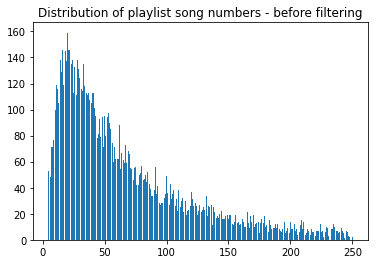

In [ ]:
x = list_song_num.keys()
y = list_song_num.values()

plt.title('Distribution of playlist song numbers - before filtering')
plt.bar(x, y)
plt.show()

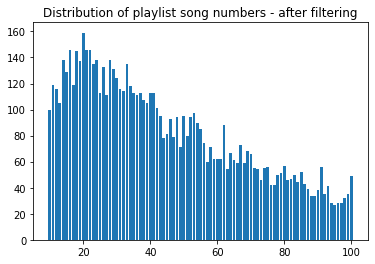

In [ ]:
x = list_song_num.keys()
y = list_song_num.values()

plt.title('Distribution of playlist song numbers - after filtering')
plt.bar(x, y)
plt.show()

In [ ]:
x1 = list(x)
y1 = list(y)

list_count = sum(y1)
total = 0
for i in range(len(x1)):
  total += x1[i] * y1[i]
print('Average length of the list: ', total / list_count)

Average length of the list:  44.137084944659286


In [ ]:
print('Before filtering out unexpected playlist, total number of unique songs is: ', len(songId_song_map.keys()))

Before filtering out unexpected playlist, total number of unique songs is:  170089


In [ ]:
print('Before filtering out unexpected playlist, total number of playlists is: ', len(all_playlists))

Before filtering out unexpected playlist, total number of playlists is:  10000


In [ ]:
print('After filtering out unexpected playlist, total number of unique songs is: ', len(songId_song_map.keys()))

After filtering out unexpected playlist, total number of unique songs is:  105066


In [ ]:
print('Before filtering out unexpected playlist, total number of playlists is: ', len(train_list) + len(test_list))

Before filtering out unexpected playlist, total number of playlists is:  7499


In [ ]:
print('Number of train playlists:', len(train_list))
print('Number of test playlists:', len(test_list))

Number of train playlists: 7129
Number of test playlists: 370


In [ ]:
# save dataset
with open('/content/drive/MyDrive/DATA 240 Data Mining/240_project/Code/yxz/train_10000.txt', 'w') as f:
  f.write('\n'.join([' '.join(i) for i in train_list]))
f.close()

with open('/content/drive/MyDrive/DATA 240 Data Mining/240_project/Code/yxz/test_10000.txt', 'w') as f:
  f.write('\n'.join([' '.join(i) for i in test_list]))
f.close()

In [ ]:
# save songid to artist map
with open('/content/drive/MyDrive/DATA 240 Data Mining/240_project/Code/yxz/songId_artist_map_10000.json', 'w') as outfile:
  json.dump(songId_artist_map, outfile)

# save songid to song map
with open('/content/drive/MyDrive/DATA 240 Data Mining/240_project/Code/yxz/songId_song_map_10000.json', 'w') as outfile:
  json.dump(songId_song_map, outfile)

NameError: ignored

# Model Train

skip-gram model: more compatible for the task

Evaluation matrics: R-Precision

In [ ]:
def check_vocabulary(song):
  return song in w2v_10k.wv.vocab

In [ ]:
def create_list_similar(list_songid, n):
    input_list = list_songid
    pred_list = []
    for i in range(n):
      similar = w2v_10k.wv.most_similar(positive = input_list,topn = 1)
      input_list.append(similar[0][0])
      pred_list.append(similar[0][0])
    return pred_list

In [ ]:
def rp_one_by_one(input_list, test_num, pred_num):
  # split test_list to two lists
  # one for predict
  # one for validation 
  test_list = []
  check_list = []
  true_count = 0
  for i in range(test_num):
    test_list.append(input_list[i])
  for i in range(pred_num):
    check_list.append(input_list[test_num + i])
  pred_list = create_list_similar(test_list, pred_num)
  for song in pred_list:
    if song in check_list:
      true_count += 1
  rp = true_count / pred_num
  return rp

In [ ]:
test_10k = TextLine2Line('/content/drive/MyDrive/DATA 240 Data Mining/240_project/Code/yxz/test_10000.txt') 

In [ ]:
# test_num = 15
# pred_num = 15

# rp_one = []
# count = 0
# for line in test_10k:
#   test = []
#   for song in line:
#     if check_vocabulary(song):
#       test.append(song)

#   list_len = len(test)
#   if list_len < test_num + pred_num:
#     continue
#   else:
#     r_score = rp_one_by_one(test, test_num, pred_num)
#     rp_one.append(r_score)
#     count += 1
# print('rp for one after one prediction: {}%'.format(round(sum(rp_one)/len(rp_one)*100, 2)))
# print(count)

rp for one after one prediction: 9.35%
196


text line reader

In [ ]:
class TextLine2Line: 
    def __init__(self, filepath): 
        self.filepath = filepath 

    def __iter__(self): 
        for line in open(self.filepath): 
            yield line.split() 

In [ ]:
train_10k = TextLine2Line('/content/drive/MyDrive/DATA 240 Data Mining/240_project/Code/yxz/train_10000.txt') 

Grid Search Model Training

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

Hyper-parameters

In [ ]:
# Ignores all words with total frequency lower than this.
min_count = [3, 5, 10, 15, 30, 50]
# Maximum distance between the current and predicted word within a sentence
window = [3, 5, 10]
# uniform size of dimension of the output vectors for each word
size = [50, 100, 150, 200, 300]
# negative sampling will be used, the int for negative specifies 
# how many “noise words” should be drawn (usually between 5-20)
negative = [5, 10, 15, 20]

In [ ]:
lowest_rp = 0
hy_params = {}
test_num = 20
pred_num = 20

for minCount in min_count:
  for winDow in window:
    for s in size:
      for neg in negative:
        w2v_10k = Word2Vec(train_10k,
                          min_count=minCount,
                          window=winDow,
                          size=s, 
                          negative=neg,
                          sg=1,
                          iter=5)
        
        rp_one = []
        for line in test_10k:
          test = []
          for song in line:
            if check_vocabulary(song):
              test.append(song)

          list_len = len(test)
          if list_len < test_num + pred_num:
            continue
          else:
            r_score = rp_one_by_one(test, test_num, pred_num)
            rp_one.append(r_score)
        local_rp = sum(rp_one)/len(rp_one)

        if local_rp > lowest_rp:
          lowest_rp = local_rp
          hy_params['MinCount'] = minCount
          hy_params['Window'] = winDow
          hy_params['Size'] = s
          hy_params['Negative'] = neg
          print(lowest_rp)
          print(hy_params)

0.02425742574257425
{'MinCount': 3, 'Window': 3, 'Size': 50, 'Negative': 5}
0.03118811881188118
{'MinCount': 3, 'Window': 3, 'Size': 50, 'Negative': 10}
0.03415841584158413
{'MinCount': 3, 'Window': 3, 'Size': 100, 'Negative': 10}
0.036633663366336625
{'MinCount': 3, 'Window': 3, 'Size': 300, 'Negative': 5}
0.038414634146341456
{'MinCount': 5, 'Window': 3, 'Size': 50, 'Negative': 10}
0.04390243902439023
{'MinCount': 5, 'Window': 3, 'Size': 100, 'Negative': 5}
0.04512195121951219
{'MinCount': 5, 'Window': 3, 'Size': 200, 'Negative': 5}
0.04741379310344827
{'MinCount': 10, 'Window': 3, 'Size': 50, 'Negative': 10}
0.049999999999999996
{'MinCount': 10, 'Window': 5, 'Size': 50, 'Negative': 15}
0.05
{'MinCount': 10, 'Window': 10, 'Size': 100, 'Negative': 20}
0.06142857142857144
{'MinCount': 15, 'Window': 10, 'Size': 50, 'Negative': 10}
0.0642857142857143
{'MinCount': 15, 'Window': 10, 'Size': 50, 'Negative': 15}
0.06818181818181818
{'MinCount': 30, 'Window': 10, 'Size': 100, 'Negative': 15}


Check the length of the song list

In [ ]:
# 10 10 100 20
test_num = 20
pred_num = 20
count = 0
w2v_10k = Word2Vec(train_10k,
                          min_count=10,
                          window=10,
                          size=100, 
                          negative=20,
                          sg=1,
                          iter=5)
for line in test_10k:
  test = []
  for song in line:
    if check_vocabulary(song):
      test.append(song)
  list_len = len(test)
  if list_len >= test_num + pred_num:
    count += 1

print('playlist amount is: ', count)

playlist amount is:  58


In [ ]:
# 15 10 50 10
test_num = 20
pred_num = 20
count = 0
w2v_10k = Word2Vec(train_10k,
                          min_count=15,
                          window=10,
                          size=50, 
                          negative=10,
                          sg=1,
                          iter=5)
for line in test_10k:
  test = []
  for song in line:
    if check_vocabulary(song):
      test.append(song)
  list_len = len(test)
  if list_len >= test_num + pred_num:
    count += 1

print('playlist amount is: ', count)

playlist amount is:  35


In [ ]:
# 'MinCount': 3, 'Window': 3, 'Size': 300, 'Negative': 5
test_num = 20
pred_num = 20
count = 0
w2v_10k = Word2Vec(train_10k,
                          min_count=3,
                          window=3,
                          size=300, 
                          negative=5,
                          sg=1,
                          iter=5)
for line in test_10k:
  test = []
  for song in line:
    if check_vocabulary(song):
      test.append(song)
  list_len = len(test)
  if list_len >= test_num + pred_num:
    count += 1

print('playlist amount is: ', count)

playlist amount is:  101


In [ ]:
# 'MinCount': 5, 'Window': 3, 'Size': 200, 'Negative': 5
test_num = 20
pred_num = 20
count = 0
w2v_10k = Word2Vec(train_10k,
                          min_count=5,
                          window=3,
                          size=200, 
                          negative=5,
                          sg=1,
                          iter=5)
for line in test_10k:
  test = []
  for song in line:
    if check_vocabulary(song):
      test.append(song)
  list_len = len(test)
  if list_len >= test_num + pred_num:
    count += 1

print('playlist amount is: ', count)

playlist amount is:  82


pick 'MinCount': 5, 'Window': 3, 'Size': 200, 'Negative': 5

iterate 100 times

In [ ]:
lowest_rp = 0
test_num = 20
pred_num = 20

ite = [5, 10, 15, 20, 25, 30, 40, 50]
for i in ite:
  w2v_10k = Word2Vec(train_10k,
                    min_count=5,
                    window=3,
                    size=200, 
                    negative=5,
                    sg=1,
                    iter=i)

  rp_one = []
  for line in test_10k:
    test = []
    for song in line:
      if check_vocabulary(song):
        test.append(song)

    list_len = len(test)
    if list_len < test_num + pred_num:
      continue
    else:
      r_score = rp_one_by_one(test, test_num, pred_num)
      rp_one.append(r_score)
  local_rp = sum(rp_one)/len(rp_one)

  if local_rp > lowest_rp:
    lowest_rp = local_rp
    print('rp = ', lowest_rp)
    print('iteration = ', i)

rp =  0.04390243902439023
iteration =  5


In [ ]:
# try different learning rate
alpha = [0.01, 0.005, 0.003, 0.001]
min_alpha = [0.0001, 0.00005, 0.00001]
lowest_rp = 0

for a in alpha:
  for m in min_alpha:

    w2v_10k = Word2Vec(train_10k,
                        min_count=5,
                        window=3,
                        size=200, 
                        negative=5,
                        sg=1,
                        iter=50,
                       alpha=a,
                       min_alpha=m)
    rp_one = []
    for line in test_10k:
      test = []
      for song in line:
        if check_vocabulary(song):
          test.append(song)

      list_len = len(test)
      if list_len < test_num + pred_num:
        continue
      else:
        r_score = rp_one_by_one(test, test_num, pred_num)
        rp_one.append(r_score)
    local_rp = sum(rp_one)/len(rp_one)
    if local_rp > lowest_rp:
      lowest_rp = local_rp
      print(local_rp)
      print('alpha = ', a)
      print('min_alpha = ', m)

0.033536585365853654
alpha =  0.01
min_alpha =  0.0001
0.03414634146341463
alpha =  0.01
min_alpha =  1e-05
0.03902439024390243
alpha =  0.003
min_alpha =  0.0001


In [ ]:
w2v_10k.save('/content/drive/MyDrive/DATA 240 Data Mining/240_project/Code/yxz/w2v_10k_final')

most frequent songs

#path

In [8]:
w2v_10k_final = models.Word2Vec.load('/content/drive/MyDrive/DATA 240 Data Mining/240_project/Code/yxz/w2v_10k_final')

In [9]:
most_freq = w2v_10k_final.wv.index2word[:20]

In [16]:
print('Top 20 most popular songs:')
print('-------------------------')
songname = []
artist = []
counts = []
for song in most_freq:
  vocab_obj = w2v_10k_final.wv.vocab[song]
  counts.append(vocab_obj.count)
  songname.append(songId_song_map[song])
  artist.append(songId_artist_map[song])
df = pd.DataFrame(list(zip(songname, artist, counts)),
               columns =['Song Name', 'Artist Name', 'frequency'])
df

Top 20 most popular songs:
-------------------------


,Song Name,Artist Name,frequency
0,HUMBLE.,Kendrick Lamar,254
1,Closer,The Chainsmokers,240
2,Broccoli (feat. Lil Yachty),DRAM,219
3,One Dance,Drake,215
4,Congratulations,Post Malone,204
5,Caroline,Aminé,188
6,Shape of You,Ed Sheeran,174
7,iSpy (feat. Lil Yachty),KYLE,173
8,Bad and Boujee (feat. Lil Uzi Vert),Migos,173
9,Ignition - Remix,R. Kelly,168


In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
#        plt.annotate(labels[i],
#                     xy=(x[i], y[i]),
#                     xytext=(5, 2),
#                     textcoords='offset points',
#                     ha='right',
#                     va='bottom')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


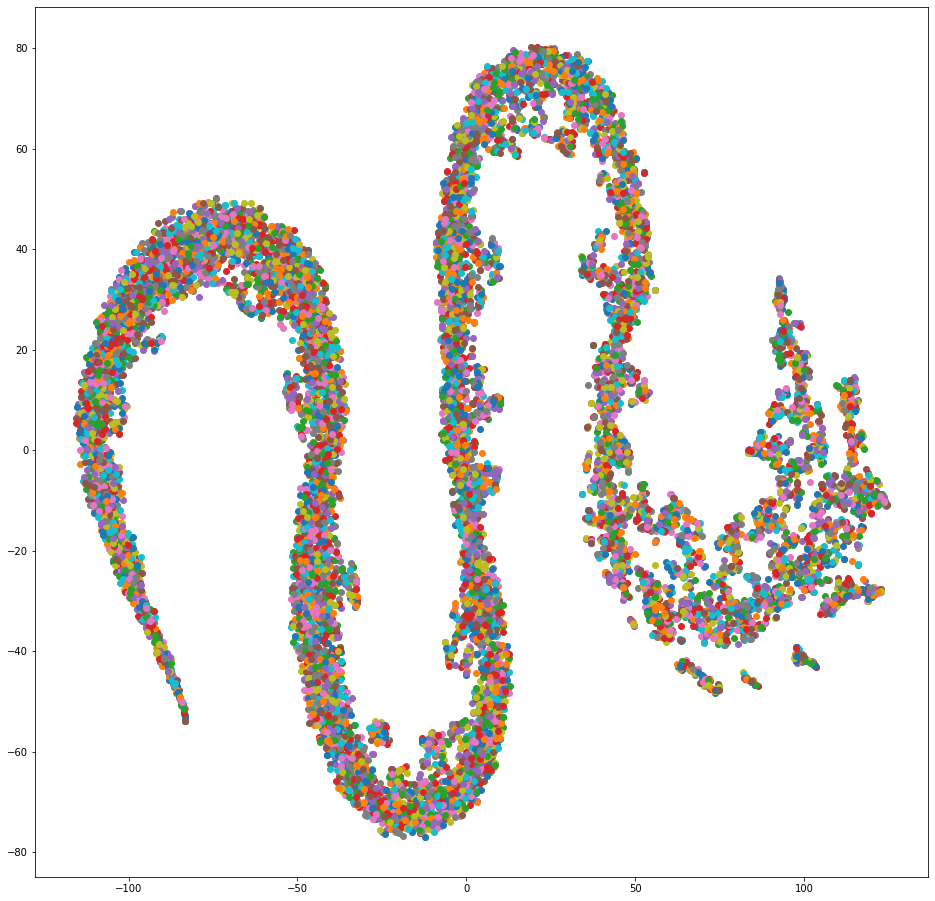

In [ ]:
tsne_plot(w2v_10k_final)